In [117]:
#%%capture

#!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'
#!pip install transformers
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime
#from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
#from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from fhnw.nlp.utils.preprocess import preprocess
tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


Laden der Daten

In [118]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)


data_train["split"] = "train"
data_test["split"] = "test"
data_all = pd.concat([data_train, data_test])
data = data_train

In [119]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

# XGB Basline
Encoden der 9 Labels

In [120]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_code = le.fit(data_train['label'].drop_duplicates())
#y_train 

In [121]:
label = pd.DataFrame(data_train['label'].drop_duplicates(inplace=False))
label.reset_index(inplace = True, drop = True)
label

,label
0,Sport
1,Kultur
2,Web
3,Wirtschaft
4,Inland
5,Etat
6,International
7,Panorama
8,Wissenschaft


Vorbereiten der Daten und kurzer check der längen.

In [122]:
X_train = data['text_original']
X_test = data_test['text_original']
y_train = label_code.transform(data['label'])
y_true = label_code.transform(data_test['label'])
print(len(y_train),len(y_true), len(X_test))


9245 1028 1028


Der untere Code importiert das stopwords-Korpus aus dem Natural Language Toolkit (NLTK) und lädt die erforderlichen Ressourcen für deutsche Stoppwörter herunter. Anschließend erstellt er eine Menge deutscher Stoppwörter und speichert sie in der Variablen stopwords.

In [123]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stopwords = set(stopwords.words("german"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reto.steiner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reto.steiner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dieser Code importiert die xgboost-Bibliothek und erstellt ein Objekt der Klasse xgb.XGBClassifier. Das Objekt clf wird verwendet, um ein XGBoost-Modell zu trainieren und zu verwenden.

Die Parameter des Objekts clf sind wie folgt:

objective='multi:softmax': Dieser Parameter legt die Zielfunktion des Modells fest. In diesem Fall wird eine harte Klassifikation mit 9 Klassen verwendet.
num_class=9: Dieser Parameter legt die Anzahl der Klassen fest, die das Modell vorhersagen soll.
missing=0: Dieser Parameter legt den Wert fest, der als fehlend behandelt wird. In diesem Fall wird der Wert 0 verwendet.
early_stopping_rounds=10: Dieser Parameter legt die Anzahl der Runden fest, nach denen das Training gestoppt wird, wenn sich die Leistung auf einem Validierungsdatensatz nicht mehr verbessert.
seed=42: Dieser Parameter legt den Zufallssamen für das Training des Modells fest. Dies kann hilfreich sein, um die Reproduzierbarkeit des Modells zu verbessern.

In [124]:
import xgboost as xgb
clf = xgb.XGBClassifier(
    objective='multi:softmax',  # Für eine harte Klassifikation
    num_class=9,  # Anzahl der Klassen
    missing=0,  # Wert, der als fehlend behandelt wird
    #early_stopping_rounds=10,  # Frühes Stoppen nach 10 Runden ohne Verbesserung  # Zu überwachende Metriken
    seed=42  # Zufallssamen für die Wiederholbarkeit
)


Dieser Code transformiert die Trainingsdaten und Testdaten in TF-IDF-Vektoren. Die Methode fit_transform() passt das TfidfVectorizer-Objekt an die Trainingsdaten an und transformiert dann sowohl die Trainingsdaten als auch die Testdaten in TF-IDF-Vektoren.

In [125]:
def analyze(text):
    return preprocess(text, stopwords=stopwords, do_compound_word_split=True)

Vec = TfidfVectorizer(analyzer=analyze)
X_train_vec = Vec.fit_transform(X_train)
X_test_vec = Vec.fit_transform(X_test)
X_train_vec

<9245x78611 sparse matrix of type '<class 'numpy.float64'>'
	with 1508375 stored elements in Compressed Sparse Row format>

Model mit Smote trainieren,vorhersagen und bewerten

In [126]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE


# Create the pipeline
pipeline = make_pipeline(TfidfVectorizer(analyzer=analyze),
    SMOTE(random_state=12),
    clf
)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer=<function analyze at 0x00000166AFE3E1F0>)),
                ('smote', SMOTE(random_state=12)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               featur...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=0,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_class=9, num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [127]:
y_pred = pipeline.predict(X_test)


In [128]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score ,precision_score, make_scorer, recall_score

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8249027237354085
F1-Score: 0.8276742793599102
Recall: 0.8236759163908027
Precision: 0.8336218281598674


In [129]:
conf = multilabel_confusion_matrix(y_true, y_pred)

Das gleiche ohne Smote und vergleichen

In [130]:


pipeline_withot_smote = Pipeline([
         ('vec', TfidfVectorizer(analyzer=analyze)),
         ("clf", clf)
        ])

pipeline_withot_smote.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 TfidfVectorizer(analyzer=<function analyze at 0x00000166AFE3E1F0>)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=0,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_class=9, num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [131]:
y_pred = pipeline_withot_smote.predict(X_test)


In folgenden Metriken kann gesehen werden, das die Klassifizierung ohne SMOTE tendenziell besser ist

In [132]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8317120622568094
F1-Score: 0.8337614652957991
Recall: 0.8291292937022335
Precision: 0.8419076583520317


Folgend noch der Vergleich der Confusion Matrizen mit und ohne SMOTE. Die Determinante der Differenzen der Matrixen muss 0 ergeben, dies ist bei jedem Label der Fall.
Ein positives Ergebnis in der ersten Spalte bedeutet in der Folgenden Auswertung das mit SMOTE eine besser Klassifizierung stattfindet als ohne.
Somit bestätigt das ergebnis die anderen Metriken, nur bei 2 Labels ist das Ergebnis mit SMOTE besser.
Daher wird folgend ohne künstlich erzeugte Daten weitergearbeitet. Was eine mögliche Verbesserung bringen könnte, wäre Data Agumentation. Hier ein Artikel https://neptune.ai/blog/data-augmentation-nlp

In [133]:
conf_withot_smote = multilabel_confusion_matrix(y_true, y_pred)
conf1 = conf - conf_withot_smote

for i in conf1:
    print(i[0,0] + i[1,1],i[1,0] + i[0,1])
    


-1 1
-10 10
-4 4
-2 2
-4 4
4 -4
2 -2
-1 1
2 -2


# Tensorflow Baseline

In [134]:
vocab_size = 10000
BATCH_SIZE = 16
EPOCHS = 8
LEARNING_RATE = 1e-5


In [135]:
tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
)
"""
count_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='count'
)

count_vectorizer.adapt(X_train.values)
"""

tfidf_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf-idf',
    ngrams=(2, 3)
)
tfidf_vectorizer.adapt(X_train.values)
# Define the neural network architecture
model = tf.keras.Sequential([
    tfidf_vectorizer,
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Tex  (None, 10000)             1         
 tVectorization)                                                 
                                                                 
 dense_30 (Dense)            (None, 32)                320032    
                                                                 
 dense_31 (Dense)            (None, 9)                 297       
                                                                 
Total params: 320330 (1.22 MB)
Trainable params: 320329 (1.22 MB)
Non-trainable params: 1 (8.00 Byte)
_________________________________________________________________


In [137]:
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
                    .shuffle(buffer_size=len(X_train.values), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test.values, y_true))
                    .batch(BATCH_SIZE))

In [138]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5


4623/4623 [==============================] - 49s 10ms/step - loss: 0.4932 - accuracy: 0.8817 - val_loss: 2.2398 - val_accuracy: 0.6556
Epoch 2/5
4623/4623 [==============================] - 49s 11ms/step - loss: 0.1111 - accuracy: 0.9782 - val_loss: 3.6966 - val_accuracy: 0.5963
Epoch 3/5
4623/4623 [==============================] - 52s 11ms/step - loss: 0.0620 - accuracy: 0.9872 - val_loss: 1.9299 - val_accuracy: 0.7091
Epoch 4/5
4623/4623 [==============================] - 50s 11ms/step - loss: 0.0510 - accuracy: 0.9879 - val_loss: 1.9775 - val_accuracy: 0.6946
Epoch 5/5
4623/4623 [==============================] - 50s 11ms/step - loss: 0.0609 - accuracy: 0.9885 - val_loss: 2.6257 - val_accuracy: 0.7004


<AxesSubplot: xlabel='epoch'>

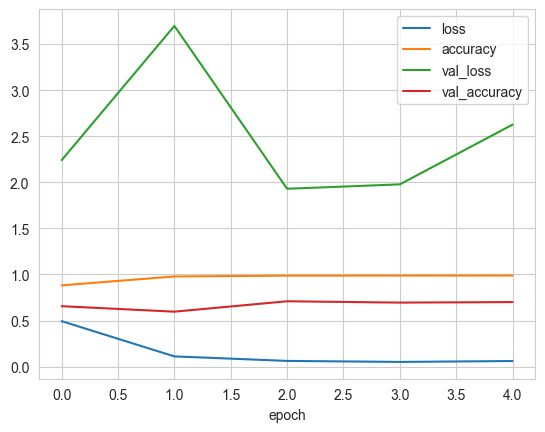

In [139]:
history_df = pd.DataFrame({'epoch': history.epoch, **history.history}).set_index('epoch')
history_df.plot()


In [140]:
result = model.predict(X_test.values)

33/33 [==============================] - 0s 11ms/step


In [141]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
y_true=label_binarizer.transform(data_test['label'])

In [142]:
result = result > .5
y_pred = result.astype(int)
conf = multilabel_confusion_matrix(y_true, y_pred)
conf

array([[[949,  12],
        [ 38,  29]],

       [[899,  27],
        [ 36,  66]],

       [[822,  55],
        [ 33, 118]],

       [[906,  68],
        [  7,  47]],

       [[829,  31],
        [ 74,  94]],

       [[887,  21],
        [  8, 112]],

       [[835,  25],
        [ 46, 122]],

       [[859,  28],
        [ 60,  81]],

       [[947,  24],
        [ 12,  45]]], dtype=int64)

In [143]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.6945525291828794
F1-Score: 0.6847189779617774
Recall: 0.7016345952002463
Precision: 0.7030112760667233


In [144]:
count_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='count'
)
vocab_size = 10000


count_vectorizer.adapt(X_train.values)


# Define the neural network architecture
model = tf.keras.Sequential([
    count_vectorizer,
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Tex  (None, 10000)             0         
 tVectorization)                                                 
                                                                 
 dense_32 (Dense)            (None, 32)                320032    
                                                                 
 dense_33 (Dense)            (None, 9)                 297       
                                                                 
Total params: 320329 (1.22 MB)
Trainable params: 320329 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [145]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5


4623/4623 [==============================] - 39s 8ms/step - loss: 0.1821 - accuracy: 0.9551 - val_loss: 0.7536 - val_accuracy: 0.8502
Epoch 2/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0210 - accuracy: 0.9958 - val_loss: 1.0742 - val_accuracy: 0.8307
Epoch 3/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0107 - accuracy: 0.9979 - val_loss: 1.3168 - val_accuracy: 0.8132
Epoch 4/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0081 - accuracy: 0.9987 - val_loss: 1.4365 - val_accuracy: 0.8268
Epoch 5/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 1.4571 - val_accuracy: 0.8327


In [146]:
result = model.predict(X_test.values)

33/33 [==============================] - 0s 7ms/step


<AxesSubplot: xlabel='epoch'>

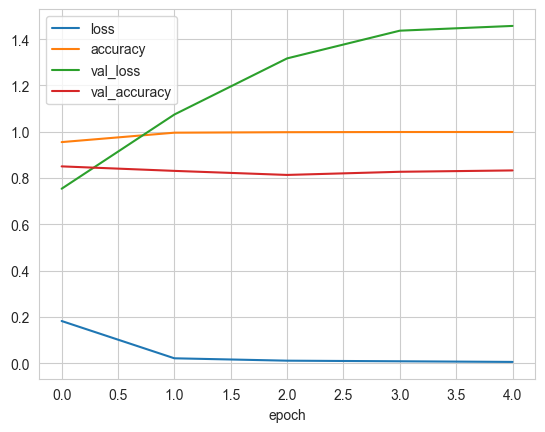

In [147]:
history_df = pd.DataFrame({'epoch': history.epoch, **history.history}).set_index('epoch')
history_df.plot()

In [148]:
result = result > .5
y_pred = result.astype(int)
conf = multilabel_confusion_matrix(y_true, y_pred)
conf

array([[[950,  11],
        [ 18,  49]],

       [[905,  21],
        [ 22,  80]],

       [[865,  12],
        [ 30, 121]],

       [[963,  11],
        [ 10,  44]],

       [[825,  35],
        [ 42, 126]],

       [[907,   1],
        [  4, 116]],

       [[847,  13],
        [ 26, 142]],

       [[843,  44],
        [ 18, 123]],

       [[961,  10],
        [  5,  52]]], dtype=int64)

In [149]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8297665369649806
F1-Score: 0.8351168059642999
Recall: 0.8309246907099357
Precision: 0.8426608503964504


Nur so aus Intresse mal noch 2 Layer hinzugefügt, um zu sehen wie das Netzwerk reagiert. Irgendwie kann ich nicht glauben das wir mit so einem Netwerk schon nahe an xgb boost sind... vielleicht irgendwo en Fehler...

In [150]:
model = tf.keras.Sequential([
    count_vectorizer,
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),   # Hidden layer with ReLU activation
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Tex  (None, 10000)             0         
 tVectorization)                                                 
                                                                 
 dense_34 (Dense)            (None, 32)                320032    
                                                                 
 dense_35 (Dense)            (None, 32)                1056      
                                                                 
 dense_36 (Dense)            (None, 32)                1056      
                                                                 
 dense_37 (Dense)            (None, 9)                 297       
                                                                 
Total params: 322441 (1.23 MB)
Trainable params: 322441 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [151]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5


4623/4623 [==============================] - 40s 8ms/step - loss: 0.2182 - accuracy: 0.9369 - val_loss: 1.1545 - val_accuracy: 0.8181
Epoch 2/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0219 - accuracy: 0.9947 - val_loss: 1.3978 - val_accuracy: 0.8171
Epoch 3/5
4623/4623 [==============================] - 40s 9ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 1.4270 - val_accuracy: 0.8356
Epoch 4/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 1.9811 - val_accuracy: 0.7870
Epoch 5/5
4623/4623 [==============================] - 39s 8ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 1.4494 - val_accuracy: 0.8405


In [152]:
result = model.predict(X_test.values)

33/33 [==============================] - 0s 7ms/step


In [153]:
result = result > .5
y_pred = result.astype(int)
conf = multilabel_confusion_matrix(y_true, y_pred)
conf

array([[[948,  13],
        [ 17,  50]],

       [[905,  21],
        [ 16,  86]],

       [[865,  12],
        [ 33, 118]],

       [[965,   9],
        [  9,  45]],

       [[815,  45],
        [ 36, 132]],

       [[905,   3],
        [  5, 115]],

       [[845,  15],
        [ 20, 148]],

       [[860,  27],
        [ 23, 118]],

       [[960,  11],
        [  8,  49]]], dtype=int64)

In [154]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8375486381322957
F1-Score: 0.8393370764917405
Recall: 0.8361916393361363
Precision: 0.8441321073024369


In [155]:
model = tf.keras.Sequential([
    count_vectorizer,
    tf.keras.layers.Dense(2**7, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Tex  (None, 10000)             0         
 tVectorization)                                                 
                                                                 
 dense_38 (Dense)            (None, 128)               1280128   
                                                                 
 dense_39 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 1281289 (4.89 MB)
Trainable params: 1281289 (4.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [156]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
4623/4623 [==============================] - 78s 17ms/step - loss: 0.1609 - accuracy: 0.9573 - val_loss: 1.0011 - val_accuracy: 0.8249
Epoch 2/5
4623/4623 [==============================] - 77s 17ms/step - loss: 0.0277 - accuracy: 0.9943 - val_loss: 1.3792 - val_accuracy: 0.8171
Epoch 3/5
4623/4623 [==============================] - 77s 17ms/step - loss: 0.0145 - accuracy: 0.9972 - val_loss: 1.4991 - val_accuracy: 0.8259
Epoch 4/5
4623/4623 [==============================] - 78s 17ms/step - loss: 0.0099 - accuracy: 0.9983 - val_loss: 1.4115 - val_accuracy: 0.8385
Epoch 5/5
4623/4623 [==============================] - 79s 17ms/step - loss: 0.0116 - accuracy: 0.9978 - val_loss: 1.7726 - val_accuracy: 0.8395


In [157]:
result = model.predict(X_test.values)
result = result > .5
y_pred = result.astype(int)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

33/33 [==============================] - 0s 9ms/step
Accuracy: 0.8365758754863813
F1-Score: 0.8376284962958606
Recall: 0.8349106960388758
Precision: 0.8418018160439481


# Fazit
Sowohl mit einfachen Neuralen Netzenohne Regulierung, wie auch mit dem XGB classifier ist ein F1-Score von 83% machbar. Habe bei diesem Notebook sehr viel gelernt. Ich hatte mich gleich auf Bertmodell etc. gestürtzt und hatte wenig Grundlagenwissen, als ich mit dem Projekt angefangen habe. Durch die Grundlagen und Computervision Prüfung musste ich mir das wissen aneignen, was mir hier kurz vor Abgabe nochmals enormer Lerneffekt gegeben hat. Ich habe sehr viele Bertmodelle versucht zu optimieren, bin aber nie über F1 von 90% gekommen. Bin gespannt was ich ich mit Regulierung in der kurzen Zeit noch schaffe aus den Basline Netzwerken zu holen.


